In [ ]:
!pip install rapidfuzz
!pip install -q -U transformers
!pip install -q -U datasets
!pip install -q -U evaluate
!pip install -q -U tokenizers
!pip install --no-deps xformers trl peft accelerate bitsandbytes

!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.7.0 requires fsspec==2025.7.0, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupt

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset, Dataset
from unsloth import FastLanguageModel
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, pipeline, EarlyStoppingCallback
import os
import pandas as pd
import ast # convert stringified dictionaries to Python dicts
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import re
from google.colab import drive


os.environ["WANDB_DISABLED"] = "true"

drive.mount('/content/gdrive')

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


    PyTorch 2.7.1+cu126 with CUDA 1208 (you have 2.6.0+cu124)
    Python  3.9.23 (you have 3.11.13)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


🦥 Unsloth Zoo will now patch everything to make training faster!
Mounted at /content/gdrive


# Load llama 3.1 8B Instruct model

In [ ]:
max_seq_length = 2048 # Choose any! Llama 3 is up to 8k
dtype = None
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    # "meta-llama/Llama-4-Maverick-17B-128E-Original", # does not appear to have a file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt or flax_model.msgpack.
    # model_name = "unsloth/Llama-4-Maverick-17B-128E", # Can't load safetensors
    # model_name = 'unsloth/Llama-3.3-70B-Instruct-GGUF', # does not appear to have a file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt or flax_model.msgpack.
    # model_name = 'meta-llama/Llama-3.3-70B-Instruct', # Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. 'llm_int8_enable_fp32_cpu_offload'
    # model_name = 'unsloth/llama-3-8b-bnb-4bit',
    # model_name = 'unsloth/Llama-3.3-70B-Instruct-bnb-4bit',
    # model_name = 'unsloth/Llama-3.2-1B-Instruct',
    model_name = 'unsloth/Llama-3.1-8B-Instruct-unsloth-bnb-4bit',
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    device_map="auto", # Automatically determine device mapping
)

==((====))==  Unsloth 2025.7.9: Fast Llama patching. Transformers: 4.53.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

# Configuring LoRA (low-rank adaptation) into our model, which allows us to efficiently update just a fraction of the model's parameters, enhancing training speed and reducing computational load.

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Low-rank dimension, suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",], # Model parameters approximated through LoRA.
    lora_alpha = 16, # Numerator for scaling factor for delta(W)
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

Unsloth 2025.7.9 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


# Create and format fine-tuning prompt for LFUD+Logic Dataset

In [ ]:

# from datasets import Dataset

# # Convert to HuggingFace Dataset with only the 'text' column
# dataset = Dataset.from_pandas(df[['text']])

# # Tokenize the dataset
# tokenized_dataset = dataset.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=512), batched=True)

data_root_path = 'gdrive/MyDrive/w266/Final Project/data'

lfud_logic_train_df = pd.read_csv(f'{data_root_path}/lfud_logic_train.csv').drop(columns = 'label')
lfud_logic_val_df = pd.read_csv(f'{data_root_path}/lfud_logic_val.csv').drop(columns = 'label')

# Format prompt text for fine-tuning
lfud_logic_train_df['text'] = lfud_logic_train_df.apply(
    lambda row: f"Classify the logical fallacy in this sentence:\nSentence: {row['input']}\nFallacy: {row['output']}",
    axis=1
)

lfud_logic_val_df['text'] = lfud_logic_val_df.apply(
    lambda row: f"Classify the logical fallacy in this sentence:\nSentence: {row['input']}\nFallacy: {row['output']}",
    axis=1
)

# Convert to HuggingFace Dataset
train_dataset_raw = Dataset.from_pandas(lfud_logic_train_df[['text']])
eval_dataset_raw = Dataset.from_pandas(lfud_logic_val_df[['text']])

# Tokenize
tokenized_train_dataset = train_dataset_raw.map(
    lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=512),
    batched=True
)
tokenized_eval_dataset = eval_dataset_raw.map(
    lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=512),
    batched=True
)

Map:   0%|          | 0/3240 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

In [ ]:
# Define training args
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = tokenized_train_dataset,
    eval_dataset = tokenized_eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs=1,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        eval_strategy="steps", # Add evaluation strategy to compute metrics
        eval_steps=10, # Evaluate every 10 steps
        metric_for_best_model="eval_loss", # Specify the metric to monitor for early stopping
        load_best_model_at_end=True, # Load the best model when training ends
    ),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Start the actual training
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,240 | Num Epochs = 1 | Total steps = 405
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
10,7.452700,7.189602
20,5.794300,5.724339
30,5.570100,5.586572
40,5.564700,5.562788
50,5.420100,5.548800
60,5.451900,5.545315
70,5.511000,5.543456
80,5.477100,5.542140
90,5.468700,5.541685
100,5.525700,5.540605


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# Save llama model

In [ ]:
# Save unsloth/Llama-3.1-8B-Instruct-unsloth-bnb-4bit
# llama_model_checkpoint_filepath = './gdrive/MyDrive/w266/Final Project/llama_3.1_model'
llama_model_checkpoint_filepath = './sample_data/llama_3.1_model_v1'
model.save_pretrained(llama_model_checkpoint_filepath)

# Load model to use again

In [ ]:
# llama_model_checkpoint_filepath = './gdrive/MyDrive/w266/Final Project/llama_3.1_model'
llama_model_checkpoint_filepath = './sample_data/llama_3.1_model_v1'
model, tokenizer = FastLanguageModel.from_pretrained(llama_model_checkpoint_filepath)

==((====))==  Unsloth 2025.7.9: Fast Llama patching. Transformers: 4.53.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


# Load LogicClimate dataset for inference

In [ ]:
# Load LogicClimate dataset for inference
logic_climate_all = pd.read_csv('https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/climate_all.csv').dropna(subset = ['source_article', 'logical_fallacies'])
logic_climate_all['logical_fallacies'] = logic_climate_all['logical_fallacies'].replace('intentional', 'intentional fallacy')

# Drop Equivocation fallacies from LogicClimate dataset

  [Li et al. (2024)](https://aclanthology.org/2024.findings-naacl.192.pdf): due to the rather vague definition of Equivocation pro vided by Jin et al. (2022), and the scarcity of such fallacy instances in real life, GPT-4 can hardly un derstand Equivocation and generate correspond ing sentences correctly. To ensure the quality of the sentences generated by GPT-4 , we neglected Equivocation fallacy type and generated the sen tences for the rest twelve logical fallacy types.


In [ ]:
# Drop Equivocation
logic_climate_all = logic_climate_all[logic_climate_all['logical_fallacies'] != 'equivocation']

# Map fallacy of logic to deductive fallacy.

[Li et al. (2024)](https://aclanthology.org/2024.findings-naacl.192.pdf) LFUD dataset: **Deductive fallacies** occur when there is a logical flaw in the reasoning behind the argument, such as Affirming the consequent, Denying the antecedent, Affirming a disjunct and so on.

According to [mappings.csv](https://github.com/causalNLP/logical-fallacy/blob/main/data/mappings.csv), **Fallacy of logic** is also known as a logical error, which is an error in the logical structure of an argument. For example, If A is true, then B is true. B is true. Therefore, A is true. (This is known as Affirming the consequent, and falls under the umbrella of deductive fallacy)

In [ ]:
# Map fallacy of logic label to deductive fallacy
logic_climate_all.loc[:, 'logical_fallacies'] = logic_climate_all['logical_fallacies'].replace('fallacy of logic', 'deductive fallacy')

# Assert fallacy labels between LFUD+Logic and LogicClimate datasets are the same
set(lfud_logic_train_df['output'].unique()) == set(logic_climate_all['logical_fallacies'].unique())

True

# Generate fallacy type predictions on LogicClimate

In [ ]:
def make_prompt(sentence):
    return (f"""Classify the logical fallacy in this sentence:
        Sentence: {sentence}
        Fallacy:""")

# Ensure max_new_tokens is short so it doesn’t generate extra
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto",
    max_new_tokens=15,
    return_full_text=False,
)

def classify_fallacy(text):
    prompt = make_prompt(text)
    output = pipe(prompt)[0]['generated_text'].strip()
    # Optionally clean or truncate if model generates extra
    return output.split('\n')[0].strip()  # only take first line

logic_climate_all['predicted_fallacy'] = logic_climate_all['source_article'].apply(classify_fallacy)

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
data_root_path = 'gdrive/MyDrive/w266/Final Project/data'
logic_climate_all.to_csv(f'{data_root_path}/logic_climate_llama_3.1_predictions.csv', index = False)

In [ ]:
logic_climate_all['predicted_fallacy'].unique()

array(['faulty generalization', 'fallacy of relevance',
       'fallacy of credibility', 'appeal to emotion', 'deductive fallacy',
       'false dilemma', 'intentional fallacy', 'fallacy of extension',
       'ad hominem', 'faulty generalizationЎыџNЎыџN', 'ad populum',
       'circular reasoning', 'false causality',
       'fallacy of relevancelásil', 'ad populumЎыџNЎыџN',
       'fallacy of relevanceılmaktadır', 'deductive fallacyЎыџNЎыџN',
       'appeal to emotionЎыџNЎыџN', 'fallacy of relevanceЎыџNЎыџN',
       'fallacy of extensionЎыџNЎыџN', 'fallacy of credibilityılmaktadır',
       'faulty generalisation', 'fallacy of relevanceЎыџNЎыџNЎыџNЎыџN',
       'fallacy of extensionlásil', 'ad populum�',
       'fallacy of credibilityЎыџNЎыџN', 'fallacy of credibilitylásil',
       'false causalityЎыџNЎыџN'], dtype=object)

# Load LogicClimate predictions again

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data_root_path = 'gdrive/MyDrive/w266/Final Project/data'

logic_climate_all = pd.read_csv(f'{data_root_path}/logic_climate_predictions.csv')

# Fuzzy match model predictions to the 12 labels

In [ ]:
from rapidfuzz import process, fuzz
valid_labels = logic_climate_all['logical_fallacies'].unique()

def clean_text(text):
    # Remove non-letter characters (keep spaces), lowercase, and trim
    return re.sub(r'[^a-zA-Z\s]', '', text).strip().lower()

def normalize_prediction(pred, valid_labels, threshold=80):
    pred_clean = clean_text(pred)
    match, score, _ = process.extractOne(
        pred_clean, valid_labels, scorer=fuzz.token_sort_ratio
    )
    return match if score >= threshold else pred_clean

# Normalize predictions
logic_climate_all['normalized_fallacy_predictions'] = logic_climate_all['predicted_fallacy'].apply(
    lambda x: normalize_prediction(x, valid_labels)
)

logic_climate_all['normalized_fallacy_predictions'] = logic_climate_all['normalized_fallacy_predictions'].str.replace('ad populumnnldnda', 'ad populum')

In [ ]:
set(logic_climate_all['normalized_fallacy_predictions'].unique()) == set(valid_labels)

True

# Evaluation reporting

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Accuracy: 0.2397

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.3621    0.2188    0.2727        96
            ad populum     0.0941    0.1270    0.1081        63
     appeal to emotion     0.4000    0.3546    0.3759       141
    circular reasoning     0.0909    0.2857    0.1379         7
     deductive fallacy     0.1636    0.1023    0.1259        88
fallacy of credibility     0.2645    0.4885    0.3432       131
  fallacy of extension     0.1132    0.2812    0.1614        64
  fallacy of relevance     0.1296    0.2718    0.1755       103
       false causality     0.2698    0.2329    0.2500        73
         false dilemma     0.6667    0.1224    0.2069        49
 faulty generalization     0.1840    0.1729    0.1783       133
   intentional fallacy     0.4921    0.1840    0.2678       337

              accuracy                         0.2397      1285
             macro avg     0.2692    0.2369    0.2170      12

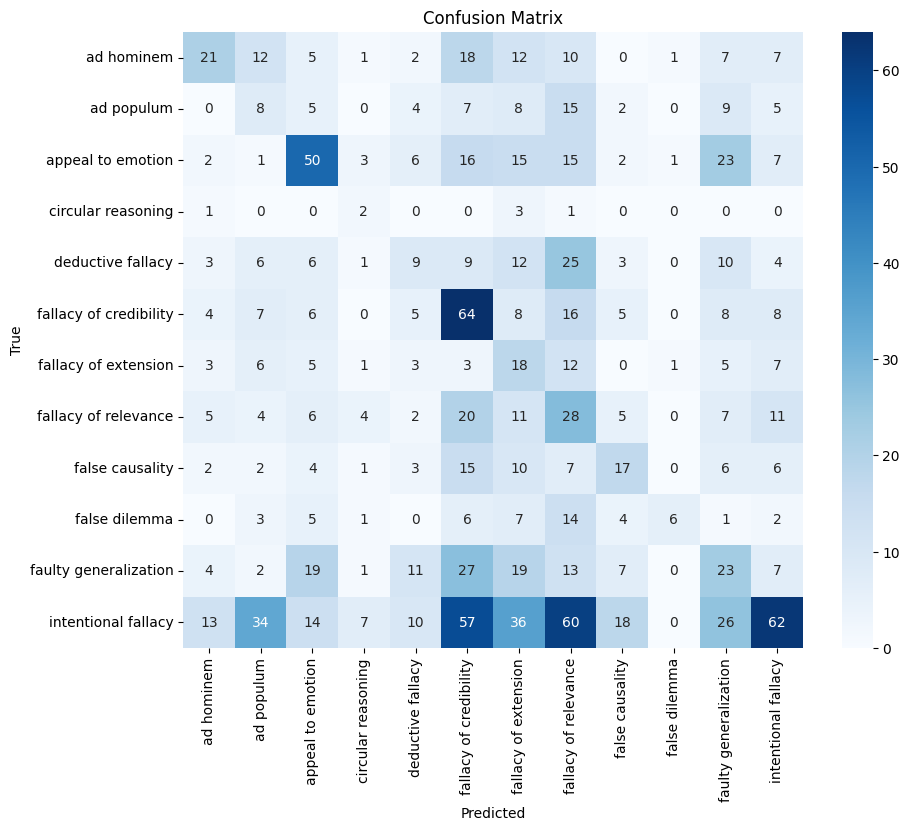

In [ ]:
# Make sure the labels are strings for compatibility
y_true = logic_climate_all['logical_fallacies'].astype(str)
y_pred = logic_climate_all['normalized_fallacy_predictions'].astype(str)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Precision, Recall, F1 per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
del model, tokenizer

# Load and retrain fresh model with r = 64, lora_alpha = 64, and lora_dropout = 0.05

# Train with new prompt containing fallacy definitions to see if there is an improvement

In [ ]:
fallacy_choices = "[ad hominem, ad populum, appeal to emotion, circular reasoning, deductive fallacy, fallacy of credibility, fallacy of extension, fallacy of relevance, false causality, false dilemma, faulty generalization, intentional fallacy]"

fallacy_definitions = (
    "Faulty generalization: drawing a conclusion from one or a few cases. "
    "False causality: assuming a causal link without evidence. "
    "Circular reasoning: the claim supports itself. "
    "Ad populum: assuming something is true because many believe it. "
    "False dilemma: presenting limited options when more exist. "
    "Fallacy of relevance: using unrelated information. "
    "Ad hominem: attacking the person instead of the argument. "
    "Appeal to emotion: relying on emotion over logic. "
    "Fallacy of extension: exaggerating an argument to attack it. "
    "Fallacy of credibility: appealing to authority without proof. "
    "Intentional fallacy: misrepresenting intent instead of content. "
    "Deductive fallacy: flawed logical structure."
)

def make_prompt(row):
    return (
        f"{fallacy_definitions}\n\n"
        f"Classify the logical fallacy in this sentence:\n"
        f"Sentence: {row['input']}\n"
        f"Choose from: {fallacy_choices}\n"
        f"Answer: {row['output']}"
    )

lfud_logic_train_df['text'] = lfud_logic_train_df.apply(make_prompt, axis=1)
lfud_logic_val_df['text'] = lfud_logic_val_df.apply(make_prompt, axis=1)


# Convert to HuggingFace Dataset
train_dataset_raw = Dataset.from_pandas(lfud_logic_train_df[['text']])
eval_dataset_raw = Dataset.from_pandas(lfud_logic_val_df[['text']])

# Tokenize
tokenized_train_dataset = train_dataset_raw.map(
    lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=512),
    batched=True
)
tokenized_eval_dataset = eval_dataset_raw.map(
    lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=512),
    batched=True
)

Map:   0%|          | 0/3240 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = 'unsloth/Llama-3.1-8B-Instruct-unsloth-bnb-4bit',
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    device_map="auto", # Automatically determine device mapping
)

# Change r and lora_alpha to 64 to capture more expressive updates, lora_dropout to 0.05 to regularize and prevent overfitting
model = FastLanguageModel.get_peft_model(
    model,
    r = 64, # Low-rank dimension, suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",], # Model parameters approximated through LoRA.
    lora_alpha = 64, # Numerator for scaling factor for delta(W)
    lora_dropout = 0.05,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = tokenized_train_dataset,
    eval_dataset = tokenized_eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs=1,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        eval_strategy="steps", # Add evaluation strategy to compute metrics
        eval_steps=10, # Evaluate every 10 steps
        metric_for_best_model="eval_loss", # Specify the metric to monitor for early stopping
        load_best_model_at_end=True, # Load the best model when training ends
    ),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# Start the actual training
trainer_stats = trainer.train()

==((====))==  Unsloth 2025.7.9: Fast Llama patching. Transformers: 4.53.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,240 | Num Epochs = 1 | Total steps = 405
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 167,772,160 of 8,198,033,408 (2.05% trained)


Step,Training Loss,Validation Loss
10,4.459000,4.167283
20,3.435400,3.394219
30,3.353900,3.369419
40,3.363800,3.365505
50,3.226700,3.363908
60,3.265400,3.360028
70,3.329500,3.360402
80,3.293800,3.357868
90,3.284300,3.357375
100,3.342200,3.357440


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
logic_climate_all['source_article']

,source_article
0,"In June last year , a severe heatwave claimed ..."
1,Diminishing sea ice is causing major walrus he...
2,A landmark report from the United Nations ’ sc...
3,"The report “ is quite a shock , and quite conc..."
4,The World Coal Association disputed the conclu...
...,...
1345,"So why are so many people worried , indeed , p..."
1346,"Global warming alarmism provides them , more t..."
1347,"Meanwhile , over the last decade , scientists ..."
1348,And crony capitalists have eagerly grabbed for...


In [ ]:
def make_prompt(sentence):
  return (
    f"{fallacy_definitions}\n\n"
    f"Classify the logical fallacy in this sentence:\n"
    f"Sentence: {sentence}\n"
    f"Choose from: {fallacy_choices}\n"
    f"Answer: "
  )

# Ensure max_new_tokens is short so it doesn’t generate extra
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto",
    max_new_tokens=15,
    return_full_text=False,
)

def classify_fallacy(text):
    prompt = make_prompt(text)
    output = pipe(prompt)[0]['generated_text'].strip()
    # Optionally clean or truncate if model generates extra
    return output.split('\n')[0].strip()  # only take first line

logic_climate_all['predicted_fallacy_v2'] = logic_climate_all['source_article'].apply(classify_fallacy)

Device set to use cuda:0


In [ ]:
logic_climate_all['predicted_fallacy_v2'].unique()

array(['false causality', 'faulty generalization',
       'fallacy of credibility', 'ad hominem', 'appeal to emotion',
       'ad populum', 'deductive fallacy', 'fallacy of relevance',
       'fallacy of credibilityЎыџNЎыџN', 'false causalitylásil',
       'fallacy of extension', 'circular reasoning', 'ad populumЎыџNЎыџN',
       'faulty generalizationЎыџNЎыџN', 'intentional fallacy', '2',
       'ad hominemЎыџNЎыџN', 'ad hominemlásil', '1‑ad populum',
       'deductive fallacyЎыџNЎыџN', 'false dilemma',
       'appeal to emotionlásil', 'circular reasoninglásil', '1',
       'false causalityЎыџNЎыџN', '4', 'appeal to emotionılmaktadır',
       'circular reasoningЎыџNЎыџN', 'deductive fallacylásil',
       '1.Intentional fallacy', 'faulty generalizationlásil',
       '2 ) deductive fallacy'], dtype=object)

In [ ]:
from rapidfuzz import process, fuzz
valid_labels = logic_climate_all['logical_fallacies'].unique()

def clean_text(text):
    # Remove non-letter characters (keep spaces), lowercase, and trim
    return re.sub(r'[^a-zA-Z\s]', '', text).strip().lower()

def normalize_prediction(pred, valid_labels, threshold=80):
    pred_clean = clean_text(pred)
    match, score, _ = process.extractOne(
        pred_clean, valid_labels, scorer=fuzz.token_sort_ratio
    )
    return match if score >= threshold else pred_clean

# Normalize predictions
logic_climate_all['normalized_fallacy_predictions_v2'] = logic_climate_all['predicted_fallacy_v2'].apply(
    lambda x: normalize_prediction(x, valid_labels)
)

logic_climate_all['normalized_fallacy_predictions_v2'].unique()
# logic_climate_all['normalized_fallacy_predictions'] = logic_climate_all['normalized_fallacy_predictions'].str.replace('ad populumnnldnda', 'ad populum')

array(['false causality', 'faulty generalization',
       'fallacy of credibility', 'ad hominem', 'appeal to emotion',
       'ad populum', 'deductive fallacy', 'fallacy of relevance',
       'fallacy of extension', 'circular reasoning',
       'intentional fallacy', '', 'false dilemma'], dtype=object)

In [ ]:
logic_climate_all['normalized_fallacy_predictions_v2'].value_counts()

,count
normalized_fallacy_predictions_v2,
faulty generalization,335
deductive fallacy,169
appeal to emotion,157
false causality,150
ad hominem,101
fallacy of credibility,100
ad populum,99
fallacy of relevance,55
circular reasoning,50


Accuracy: 0.1494

Classification Report:
                        precision    recall  f1-score   support

                           0.0000    0.0000    0.0000         0
            ad hominem     0.2376    0.2500    0.2437        96
            ad populum     0.0707    0.1111    0.0864        63
     appeal to emotion     0.2675    0.2979    0.2819       141
    circular reasoning     0.0600    0.4286    0.1053         7
     deductive fallacy     0.0592    0.1136    0.0778        88
fallacy of credibility     0.2900    0.2214    0.2511       131
  fallacy of extension     0.0750    0.0469    0.0577        64
  fallacy of relevance     0.1091    0.0583    0.0759       103
       false causality     0.1333    0.2740    0.1794        73
         false dilemma     0.1250    0.0408    0.0615        49
 faulty generalization     0.1284    0.3233    0.1838       133
   intentional fallacy     0.3750    0.0089    0.0174       337

              accuracy                         0.1494      12

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


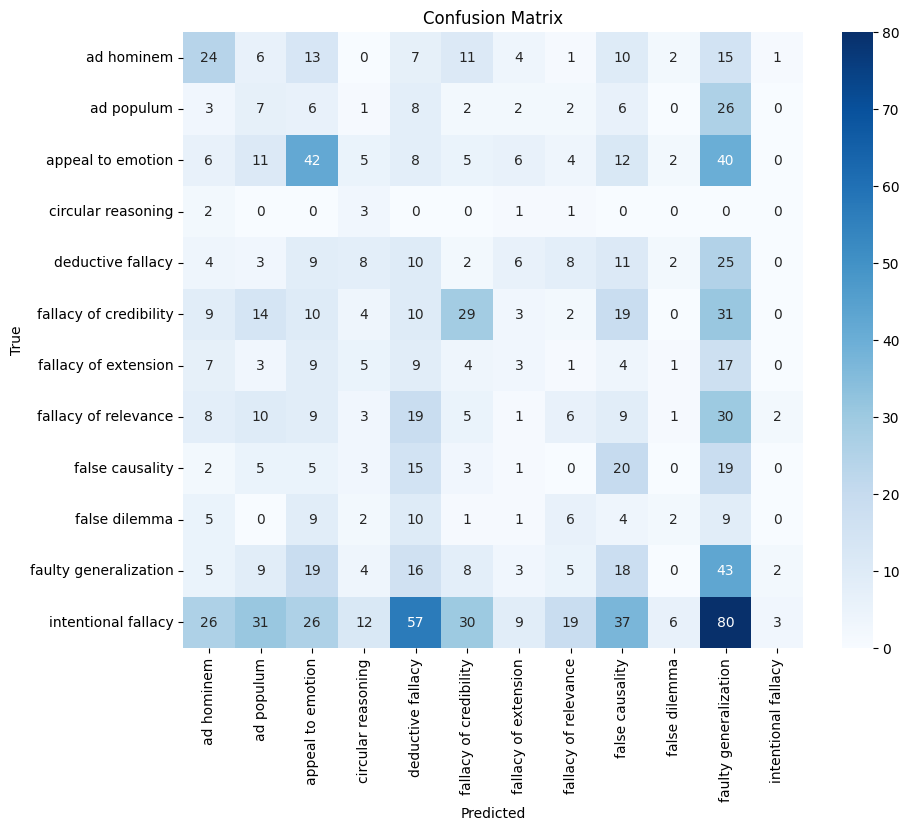

In [ ]:
# Make sure the labels are strings for compatibility
y_true = logic_climate_all['logical_fallacies'].astype(str)
y_pred = logic_climate_all['normalized_fallacy_predictions_v2'].astype(str)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Precision, Recall, F1 per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# IGNORE BELOW, OLD CODE

# Load in a fresh version of llama 3.1 and train with new prompt containing fallacy definitions to see if there is an improvement

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = 'unsloth/Llama-3.1-8B-Instruct-unsloth-bnb-4bit',
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    device_map="auto", # Automatically determine device mapping
)

==((====))==  Unsloth 2025.7.7: Fast Llama patching. Transformers: 4.53.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Low-rank dimension, suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",], # Model parameters approximated through LoRA.
    lora_alpha = 16, # Numerator for scaling factor for delta(W)
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

In [ ]:
full_context = (
  "Faulty generalization occurs when a conclusion about all or many instances of a phenomenon is drawn from one or a few instances of that phenomenon. "
  "False causality occurs when an argument jumps to a conclusion implying a causal relationship without supporting evidence. "
  "Circular reasoning occurs when an argument uses the claim it is trying to prove as proof that the claim is true. "
  "Ad populum occurs when an argument is based on affirming that something is real or better because the majority thinks so. "
  "False dilemma occurs when incorrect limitations are made on the possible options in a scenario when there could be other options. "
  "Fallacy of relevance, which is also known as Red Herring, occurs when the speaker attempts to divert attention from the primary argument by offering a point that does not suffice as counterpoint/supporting evidence (even if it is true). "
  "Ad hominem is an irrelevant attack towards the person or some aspect of the person who is making the argument, instead of addressing the argument or position directly. "
  "Appeal to emotion is when emotion is used in place of reason to support an argument in place of reason, such as pity, fear, anger, etc. Remember that the emotion must be used in place of a valid reason for supporting the conclusion. "
  "Fallacy of extension is an argument that attacks an exaggerated or caricatured version of your opponent's position. "
  "Fallacy of credibility is when an appeal is made to some form of ethics, authority, or credibility. "
  "Intentional fallacy is a custom category for when an argument has some element that shows the intent of a speaker to win an argument without actual supporting evidence. "
  "Deductive fallacy occurs when there is a logical flaw in the reasoning behind the argument, such as Affirming the consequent, Denying the antecedent, Affirming a disjunct and so on. "
)

main_prompt_sentence = "Classify the logical fallacy in this sentence. Sentence:"

# Format prompt text for fine-tuning
lfud_logic_train_df['text'] = lfud_logic_train_df.apply(
    lambda row: (f"{full_context} + {main_prompt_sentence} {row['input']}"
      "Choose from: [ad hominem, ad populum, appeal to emotion, circular reasoning, "
      "deductive fallacy, fallacy of credibility, fallacy of extension, fallacy of relevance, "
      "false causality, false dilemma, faulty generalization, intentional fallacy]"
      f"Answer: {row['output']}"),
    axis=1
)

lfud_logic_val_df['text'] = lfud_logic_val_df.apply(
    lambda row: (f"{full_context} + {main_prompt_sentence} {row['input']}"
    "Choose from: [ad hominem, ad populum, appeal to emotion, circular reasoning, "
    "deductive fallacy, fallacy of credibility, fallacy of extension, fallacy of relevance, "
    "false causality, false dilemma, faulty generalization, intentional fallacy]"
    f"Answer: {row['output']}"),
    axis=1
)

# Convert to HuggingFace Dataset
train_dataset_raw = Dataset.from_pandas(lfud_logic_train_df[['text']])
eval_dataset_raw = Dataset.from_pandas(lfud_logic_val_df[['text']])

# Tokenize
tokenized_train_dataset = train_dataset_raw.map(
    lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=512),
    batched=True
)
tokenized_eval_dataset = eval_dataset_raw.map(
    lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=512),
    batched=True
)

Map:   0%|          | 0/3240 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

In [ ]:
# Define training args
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = tokenized_train_dataset,
    eval_dataset = tokenized_eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs=1,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        eval_strategy="steps", # Add evaluation strategy to compute metrics
        eval_steps=10, # Evaluate every 10 steps
        metric_for_best_model="eval_loss", # Specify the metric to monitor for early stopping
        load_best_model_at_end=True, # Load the best model when training ends
    ),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# Start the actual training
trainer_stats = trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,240 | Num Epochs = 1 | Total steps = 405
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Step,Training Loss,Validation Loss
10,2.085600,1.941077
20,0.843400,0.803617
30,0.718200,0.748644
40,0.721900,0.734093
50,0.612400,0.727734
60,0.678500,0.724467
70,0.673300,0.721975
80,0.644500,0.720718
90,0.676700,0.719738
100,0.692700,0.718579


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# Save v2 of llama model

In [ ]:
# Save unsloth/Llama-3.1-8B-Instruct-unsloth-bnb-4bit
llama_model_checkpoint_filepath = './gdrive/MyDrive/w266/Final Project/llama_3.1_model_v2'
model.save_pretrained(llama_model_checkpoint_filepath)

In [ ]:
sentence = logic_climate_all['source_article'][0]

(f"{main_prompt_sentence} {sentence}"
        "Choose from: [ad hominem, ad populum, appeal to emotion, circular reasoning, "
        "deductive fallacy, fallacy of credibility, fallacy of extension, fallacy of relevance, "
        "false causality, false dilemma, faulty generalization, intentional fallacy]"
        f"Answer: ")

'Classify the logical fallacy in this sentence. Sentence: In June last year , a severe heatwave claimed over 1,000 lives in Karachi , Pakistan . Severe drought caused food shortages for millions of people in Ethiopia , with a lack of rainfall resulting in “ intense and widespread ” forest fires in Indonesia that belched out a vast quantity of greenhouse gas .Choose from: [ad hominem, ad populum, appeal to emotion, circular reasoning, deductive fallacy, fallacy of credibility, fallacy of extension, fallacy of relevance, false causality, false dilemma, faulty generalization, intentional fallacy]Answer: '

In [ ]:
def make_prompt(sentence):
    return (f"{full_context} + {main_prompt_sentence} {sentence}"
        "Choose from: [ad hominem, ad populum, appeal to emotion, circular reasoning, "
        "deductive fallacy, fallacy of credibility, fallacy of extension, fallacy of relevance, "
        "false causality, false dilemma, faulty generalization, intentional fallacy]"
        f"Answer: ")

In [ ]:
# Load LogicClimate dataset for inference
logic_climate_all = pd.read_csv('https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/climate_all.csv').dropna(subset = ['source_article', 'logical_fallacies'])
logic_climate_all['logical_fallacies'] = logic_climate_all['logical_fallacies'].replace('intentional', 'intentional fallacy')

# Drop Equivocation
logic_climate_all = logic_climate_all[logic_climate_all['logical_fallacies'] != 'equivocation']

# Map fallacy of logic label to deductive fallacy
logic_climate_all.loc[:, 'logical_fallacies'] = logic_climate_all['logical_fallacies'].replace('fallacy of logic', 'deductive fallacy')

# Assert fallacy labels between LFUD+Logic and LogicClimate datasets are the same
set(lfud_logic_train_df['output'].unique()) == set(logic_climate_all['logical_fallacies'].unique())

# def make_prompt(sentence):
#     return (f"{full_context} {main_prompt_sentence} {sentence}"
#         "Choose from: [ad hominem, ad populum, appeal to emotion, circular reasoning, "
#         "deductive fallacy, fallacy of credibility, fallacy of extension, fallacy of relevance, "
#         "false causality, false dilemma, faulty generalization, intentional fallacy]"
#         f"Answer: ")

# # Ensure max_new_tokens is short so it doesn’t generate extra
# pipe = pipeline(
#     "text-generation",
#     model=model,
#     tokenizer=tokenizer,
#     device_map="auto",
#     max_new_tokens=15,
#     return_full_text=False,
# )

# def classify_fallacy(text):
#     prompt = make_prompt(text)
#     output = pipe(prompt)[0]['generated_text'].strip()
#     # Optionally clean or truncate if model generates extra
#     return output.split('\n')[0].strip()  # only take first line

# logic_climate_all['predicted_fallacy_v2'] = logic_climate_all['source_article'].apply(classify_fallacy)

# data_root_path = 'gdrive/MyDrive/w266/Final Project/data'
# logic_climate_all.to_csv(f'{data_root_path}/logic_climate_llama_3.1_predictions_v2.csv', index = False)

Device set to use cuda:0


In [ ]:
allowed_labels = [
    "ad hominem", "ad populum", "appeal to emotion", "circular reasoning",
    "deductive fallacy", "fallacy of credibility", "fallacy of extension", "fallacy of relevance",
    "false causality", "false dilemma", "faulty generalization", "intentional fallacy"
]

# During inference
def classify_fallacy_generate(input_text):
    prompt = full_context + f"\n\nClassify the logical fallacy in this sentence. Sentence: {input_text}\nChoose from: {allowed_labels}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=10,
        do_sample=False,
        num_beams=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract only the answer portion
    for label in allowed_labels:
        if label in decoded.lower():
            return label
    return "unknown"

logic_climate_all['predicted_fallacy_v2'] = logic_climate_all['source_article'].apply(classify_fallacy_generate)

In [ ]:
logic_climate_all['predicted_fallacy_v2']

,predicted_fallacy_v2
0,ad hominem
1,ad hominem
2,ad hominem
3,ad hominem
4,ad hominem
...,...
1345,ad hominem
1346,ad hominem
1347,ad hominem
1348,ad hominem


In [ ]:
valid_labels = logic_climate_all['logical_fallacies'].unique()

def clean_text(text):
    # Remove non-letter characters (keep spaces), lowercase, and trim
    return re.sub(r'[^a-zA-Z\s]', '', text).strip().lower()

def normalize_prediction(pred, valid_labels, threshold=50):
    pred_clean = clean_text(pred)
    match, score, _ = process.extractOne(
        pred_clean, valid_labels, scorer=fuzz.token_sort_ratio
    )
    return match if score >= threshold else pred_clean

# Normalize predictions
logic_climate_all['normalized_fallacy_predictions'] = logic_climate_all['predicted_fallacy_v2'].apply(
    lambda x: normalize_prediction(x, valid_labels)
)

# logic_climate_all['normalized_fallacy_predictions'] = logic_climate_all['normalized_fallacy_predictions'].str.replace('ad populumnnldnda', 'ad populum')
logic_climate_all['normalized_fallacy_predictions'].value_counts()

,count
normalized_fallacy_predictions,
ad hominem,1285


In [ ]:
logic_climate_all['normalized_fallacy_predictions'].unique()

array(['ad hominem'], dtype=object)

Accuracy: 0.0747

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.0747    1.0000    0.1390        96
            ad populum     0.0000    0.0000    0.0000        63
     appeal to emotion     0.0000    0.0000    0.0000       141
    circular reasoning     0.0000    0.0000    0.0000         7
     deductive fallacy     0.0000    0.0000    0.0000        88
fallacy of credibility     0.0000    0.0000    0.0000       131
  fallacy of extension     0.0000    0.0000    0.0000        64
  fallacy of relevance     0.0000    0.0000    0.0000       103
       false causality     0.0000    0.0000    0.0000        73
         false dilemma     0.0000    0.0000    0.0000        49
 faulty generalization     0.0000    0.0000    0.0000       133
   intentional fallacy     0.0000    0.0000    0.0000       337

              accuracy                         0.0747      1285
             macro avg     0.0062    0.0833    0.0116      12

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


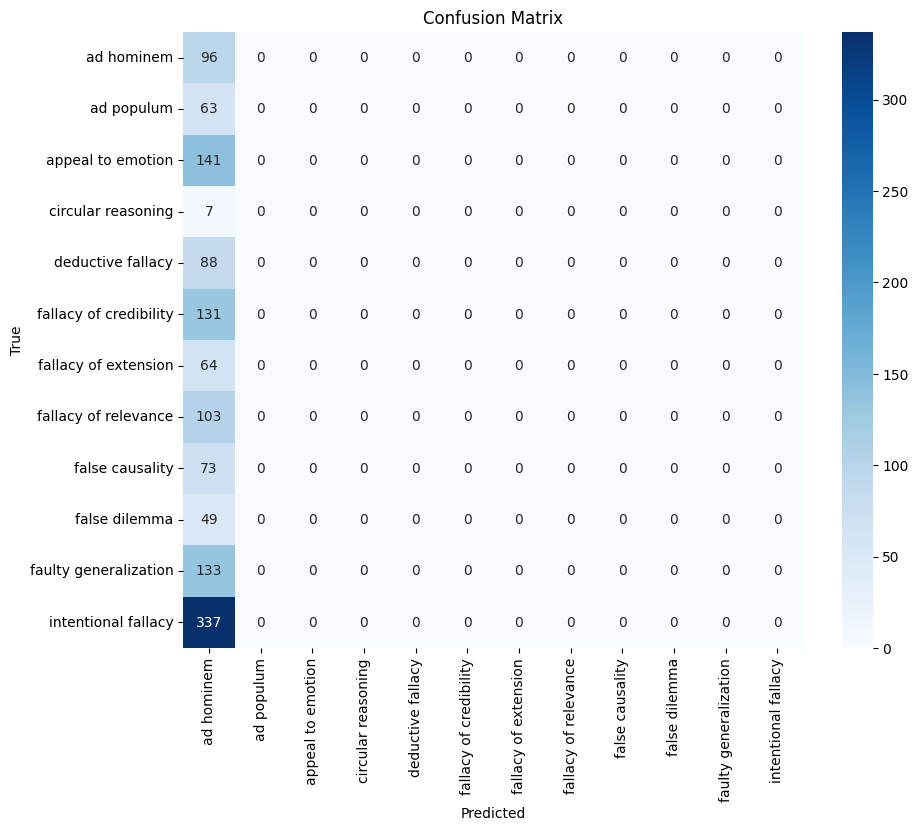

In [ ]:
# Make sure the labels are strings for compatibility
y_true = logic_climate_all['logical_fallacies'].astype(str)
y_pred = logic_climate_all['normalized_fallacy_predictions'].astype(str)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Precision, Recall, F1 per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()